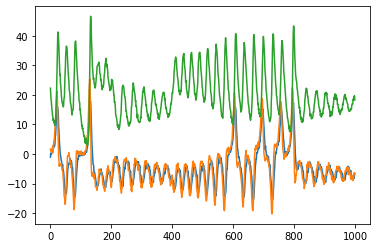

In [1]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool
import scipy.special as fun

def gen_data(rho, sigma=10, beta=2.667, initial_states=[0., 1., 1.05], obs_per_day=40, days=50, noise=0.5, linspace=1000):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = initial_states.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (sigma * (state_ls[i - 1][1] - state_ls[i - 1][0]))
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (state_ls[i - 1][0] * (rho[index]-state_ls[i - 1][2]) - state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (state_ls[i - 1][0] * state_ls[i - 1][1] - beta * state_ls[i - 1][2])
#         print(state_ls[i])
    states = state_ls[::linspace]
    states += np.random.normal(0, noise, states.shape)
    return states



torch.set_num_threads(1)
torch.set_default_dtype(torch.double)


# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    description of ODE
    theta: list[3]: [k1, k_{-1}, k2]
    return: array(n, 4)
    """
    xs = x[:, 0]
    ys = x[:, 1]
    zs = x[:, 2]
    xdt = theta[0] * (ys-xs)
    ydt = xs * (theta[1] - zs) - ys
    zdt = xs * ys - theta[2] * zs
    return np.stack([xdt, ydt, zdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[3]
    x: array(n, 4)
    return: array(n, 3, 3)
    """
    xs = x[:, 0]
    ys = x[:, 1]
    zs = x[:, 2]
    resultDx = np.zeros(shape=[np.shape(x)[0], 3, 3])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dx
    resultDx[:, 0, 0] = -theta[0]
    # (0) / dy
    resultDx[:, 1, 0] =  theta[0]
    # (1) / dx
    resultDx[:, 0, 1] = theta[1] - zs
    # (1) / dy
    resultDx[:, 1, 1] = -1.
    # (1) / dz
    resultDx[:, 2, 1] = -xs
    # (2) / dx
    resultDx[:, 0, 2] = ys
    # (2) / dy
    resultDx[:, 1, 2] = xs
    # (2) / dz
    resultDx[:, 2, 2] = -theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[3]
    x: array(n, 4)
    return: array(n, 3, 4)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 3, 3])
    # [:, i, j]: jth equation derivative of the ith theta
    xs = x[:, 0]
    ys = x[:, 1]
    zs = x[:, 2]
    # (0) / dsigma
    resultDtheta[:, 0, 0] = ys - xs
    # (1) / drho
    resultDtheta[:, 1, 1] = xs
    # (2) / dbeta
    resultDtheta[:, 2, 2] = -zs
    return resultDtheta


def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    xs = x[:, 0]
    ys = x[:, 1]
    zs = x[:, 2]
    xdt = constant_param_ls[0] * (ys-xs)
    ydt = xs * (theta[:, 0] - zs) - ys
    zdt = xs * ys - constant_param_ls[1] * zs
    return torch.stack([xdt, ydt, zdt], axis=1)

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])


def calibration_construct(vals, occurence_times_2):
    ls = []
    for idx in range(len(occurence_times_2)):
        for repeat_num in range(occurence_times_2[idx]):
            ls.append(vals[idx])
    return torch.cat(ls, axis=0)


class Bessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp, nu):
        ctx._nu = nu
        ctx.save_for_backward(inp)
        mat = fun.kv(nu, inp.detach().numpy())
        return (torch.from_numpy(np.array(mat)))

    @staticmethod
    def backward(ctx, grad_out):
        inp, = ctx.saved_tensors
        nu = ctx._nu
        grad_in = grad_out.numpy() * np.array(fun.kvp(nu, inp.detach().numpy()))
        return (torch.from_numpy(grad_in), None)


class generalMatern(object):

    # has_lengthscale = True

    def __init__(self, nu, lengthscale, **kwargs):
        # super(Matern,self).__init__(**kwargs)
        self.nu = nu
        self.log_lengthscale = torch.tensor(np.log(lengthscale))
        self.log_lengthscale.requires_grad_(True)

    def _set_lengthscale(self, lengthscale):
        self.log_lengthscale = torch.tensor(np.log(lengthscale))

    def lengthscale(self):
        return (torch.exp(self.log_lengthscale).item())

    def forward(self, x1, x2=None, **params):
        lengthscale = torch.exp(self.log_lengthscale)
        x1 = x1.squeeze()
        if x2 is None: x2 = x1
        r_ = (x1.reshape(-1, 1) - x2.reshape(1, -1)).abs()
        r_ = np.sqrt(2. * self.nu) * r_ / lengthscale
        # handle limit at 0, allows more efficient backprop
        r_ = torch.clamp(r_, min=1e-15)
        C_ = np.power(2, 1 - self.nu) * np.exp(-fun.loggamma(self.nu)) * torch.pow(r_, self.nu)
        mat = Bessel.apply(r_, self.nu)
        C_ = C_ * mat
        return (C_)

    def C(self, x1, x2=None):
        return (self.forward(x1, x2).detach())


def GPTrain(train_x, train_y, nu, lengthscale_lb=5., learning_rate=1e-6, noisy=True, max_iter=5, verbose=False,
            eps=1e-6):
    # preprocess input data
    n = train_x.size(0)
    # normalized x to 0 and 1
    x_range = [torch.min(train_x).item(), torch.max(train_x).item()]
    train_x = (train_x - x_range[0]) / (x_range[1] - x_range[0])
    #     train_x[0] = eps
    # set up kernel
    kernel = generalMatern(nu=nu, lengthscale=1.1 * lengthscale_lb / (x_range[1] - x_range[0]))
    # lambda = noise/outputscale
    log_lambda = torch.tensor(np.log(1e-2))
    log_lambda.requires_grad_(True)
    loglb_normalized = torch.log(torch.tensor(lengthscale_lb / (x_range[1] - x_range[0])))
    optimizer = torch.optim.LBFGS([kernel.log_lengthscale, log_lambda], lr=learning_rate)
    # training
    prev_loss = np.Inf
    for i in range(max_iter):
        R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
        e, v = torch.eig(R, eigenvectors=True)
        e = e[:, 0]  # eigenvalues
        a = v.T @ torch.ones(n)
        b = v.T @ train_y
        mean = ((a / e).T @ b) / ((a / e).T @ a)
        d = v.T @ (train_y - mean)
        outputscale = 1. / n * (d / e).T @ d

        def closure():
            optimizer.zero_grad()
            R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
            e, v = torch.eig(R, eigenvectors=True)
            e = e[:, 0]  # eigenvalues
            a = v.T @ torch.ones(n)
            b = v.T @ train_y
            mean = ((a / e).T @ b) / ((a / e).T @ a)
            d = v.T @ (train_y - mean)
            outputscale = 1. / n * (d / e).T @ d
            loss = torch.log(outputscale) + torch.mean(torch.log(e))
            tmp0 = torch.clamp(kernel.log_lengthscale, max=0.)
            loss = loss + 1e3 * torch.sum(torch.square(kernel.log_lengthscale - tmp0))
            tmp = torch.clamp(kernel.log_lengthscale, min=loglb_normalized)
            loss = loss + 1e3 * torch.sum(torch.square(kernel.log_lengthscale - tmp))
            tmp2 = torch.clamp(log_lambda, min=np.log(1e-6))
            loss = loss + 1e3 * torch.sum(torch.square(log_lambda - tmp2))
            loss.backward()
            return loss

        optimizer.step(closure)

    R = kernel.forward(train_x) + torch.exp(log_lambda) * torch.eye(n)
    Rinv = torch.inverse(R)
    ones = torch.ones(n)
    mean = ((ones.T @ Rinv @ train_y) / (ones.T @ Rinv @ ones)).item()
    outputscale = (1 / n * (train_y - mean).T @ Rinv @ (train_y - mean)).item()
    noisescale = outputscale * torch.exp(log_lambda).item()
    return outputscale


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                     priorTemperature, bound=None):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[0][2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0][0]
    #  prior distriobution of X-
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0)
    for i in range(pdimension):
        res[i, 2] /= priorTemperature[i][1]
    if bound:
        extra_loss = torch.tensor([0.])
        for i in range(len(time_constant_param_ls)):
            extra_loss -= 1e20 * torch.square(time_constant_param_ls[i]-torch.clamp(time_constant_param_ls[i], min=bound[i].item() - 0.0001))
            extra_loss -= 1e20 * torch.square(time_constant_param_ls[i]-torch.clamp(time_constant_param_ls[i], max=bound[i].item() + 0.0001))
        return torch.sum(res) + torch.sum(extra_loss), res.detach().numpy()
    return torch.sum(res), res.detach().numpy()


def construct_kernel(dimension, covAllDimensions):
    PyList = []
    for each_gpcov in covAllDimensions:
        p_K = np.array(each_gpcov.mphi) @ np.array(each_gpcov.C)
        K_pp = np.array(each_gpcov.Kphi) - p_K @ np.array(each_gpcov.Cinv) @ p_K
        Cinv_tmp = np.linalg.pinv(np.array(each_gpcov.C)[:dimension, :dimension], hermitian=True)
        mphi_tmp = p_K[:dimension, :dimension] @ Cinv_tmp
        K_tmp = K_pp[:dimension, :dimension] + p_K[:dimension, :dimension] @ Cinv_tmp @ p_K[:dimension, :dimension]
        Kinv_tmp = np.linalg.pinv(K_tmp, hermitian=True)
        each_pycov = dict(
        Cinv=torch.tensor(Cinv_tmp),
        Kinv=torch.tensor(Kinv_tmp),
        mphi=torch.tensor(mphi_tmp),
    )
        PyList.append(each_pycov)
    return PyList

def main_func(random_idx):
    np.random.seed(random_idx)
    n1 = np.random.randint(200, 300)
    np.random.seed(random_idx+1)
    n2 = np.random.randint(400, 500)
    rho = np.concatenate((28 * np.ones(1200000), 18 * np.ones(n1 * 1000), 28 * np.ones(n2 * 1000), 18 * np.ones((800-n1-n2) * 1000)))
    yobs_np = gen_data(rho)[1000:]
    rho0 = rho[::1000][1000:]
    max_kernel_size = 40
    discretization = 1
    obs_per_day = 40 
    days = 1
    theta_lowerbound=np.array([0., 0., 0.])
    theta_upperbound=np.array([np.inf, np.inf, np.inf])
    param_names = ['sigma', 'rho', 'beta']
    is_time_varying=[False, True, False] 
    use_trajectory='inferred'
    learning_rate=np.array([1e-4, 1e-3, 1e-5])
    n_iter = [15001, 200000, 15000, 200000]

    yobs = yobs_np[:40]
    start_time = time.time()
    nobs, p_dim = yobs.shape[0], yobs.shape[1]
    n_points = nobs * discretization
    theta_dim = theta_lowerbound.shape[0]
    d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
    for i in range(n_points):
        for j in range(n_points):
            if i > j:
                d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
            else:
                d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
    Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                             thetaLowerBound=theta_lowerbound,
                             thetaUpperBound=theta_upperbound)
    tvecObs = np.arange(0, days, 1. / obs_per_day)
    tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
    yFull = np.ndarray([n_points, p_dim])
    yFull.fill(np.nan)
    yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
    xInitExogenous = np.zeros_like(yFull)
    # interpolate: find the ydata of tvecFull given observations
    for i in range(p_dim):
        xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
    # First stage: use MAGI package to optimize theta as constant
    result = solve_magi(
        yFull,
        Ode_system,
        tvecFull,
        sigmaExogenous=np.array([]),
        phiExogenous=np.array([[]]),
        xInitExogenous=xInitExogenous,
        thetaInitExogenous=np.array([]),
        muExogenous=np.array([[]]),
        dotmuExogenous=np.array([[]]),
        priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
        priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
        priorTemperatureObs=1.0,
        kernel="generalMatern",
        nstepsHmc=100,
        burninRatioHmc=0.5,
        niterHmc=n_iter[0],
        stepSizeFactorHmc=0.01,
        nEpoch=1,
        bandSize=40,
        useFrequencyBasedPrior=True,
        useBand=False,
        useMean=False,
        useScalerSigma=False,
        useFixedSigma=False,
        verbose=True)
    samplesCpp = result['samplesCpp']
    llikId = 0
    xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
    # dimension of theta
    thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
    sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
    burnin = int(n_iter[0] * 0.5)
    xsampled = samplesCpp[xId, (burnin + 1):]
    xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
    CovAllDimensionsPyList = []
    thetaSampled = samplesCpp[thetaId, (burnin + 1):]
    inferred_theta = np.mean(thetaSampled, axis=-1)
    sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
    inferred_sigma = np.mean(sigmaSampled, axis=-1)
    inferred_trajectory = np.mean(xsampled, axis=-1)
    for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)
    

    
    batch_size = 1
    n_batch = 900
    regret_length = 5
    torch.set_default_dtype(torch.double)    
    is_time_varying=[False, True, False] 
    result_ls = []
    cpd_ls = []
    latentx_ls = []
    h0_x_ls= []
    h1_x_ls= []
    psi_ls = []
    indicator_ls = []
    history_value = torch.tensor(inferred_theta[1] * torch.ones(days * obs_per_day)).reshape(-1, 1)
    history_indicator = np.zeros(len(history_value))
    init_scale = np.zeros(yobs_np.shape[1])
    for EachDim in range(yobs_np.shape[1]):
        initial_scale = GPTrain(torch.tensor(np.linspace(0., 1., 40)),torch.tensor(yobs_np[:40])[:, EachDim], 2.01)
#         print(initial_scale)
        init_scale[EachDim] = initial_scale            
    sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
    time_constant_param_ls = [] # List[tensor[1], tensor[1], tensor[1], tensor[1]]
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == False:
            param_name = param_names[thetaEachDim]
            globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # , requires_grad=True
            time_constant_param_ls.append(eval(param_name))

    kernel_size = 40
    regret_length = 10
    skip = 0
    for EachBatch in range(n_batch):
        print('Batch ' + str(EachBatch))
        if skip:
            skip -= 1
            result_ls.append('*')
            history_indicator = np.concatenate([history_indicator[1:], np.array([history_indicator[-1]])])
            history_value = torch.cat((history_value[1:], history_value[-1].reshape(1, -1)))
            continue

        previous_psi = []
        for each in time_constant_param_ls:
            previous_psi.append(each.detach().clone())
        print(previous_psi)
        start_idx = int(EachBatch * batch_size)+regret_length
        end_idx = int(EachBatch * batch_size + days * obs_per_day)+regret_length
#         print(rho0[end_idx])
        # each time update one step
        history_indicator = np.concatenate([history_indicator[1:], np.array([history_indicator[-1]])])
        history_value = torch.cat((history_value[1:], history_value[-1].reshape(1, -1)))
        if kernel_size < 40:
            # update kernel
            print('kernel_size: ', kernel_size)
            yobs = yobs_np[end_idx - kernel_size:end_idx]
            tmp_CovAllDimensionsPyList = construct_kernel(kernel_size, result['result_solved'].covAllDimensions)
            window_scale = np.zeros(yobs.shape[1])
            for EachDim in range(yobs.shape[1]):
                scale = GPTrain(torch.tensor(np.linspace(1./40, kernel_size/40, kernel_size)),torch.tensor(yobs)[:, EachDim], 2.01)
                window_scale[EachDim] = scale
            ydata = torch.from_numpy(yobs).double()
            priorTemperature = torch.tensor([[1, max(window_scale[0] / init_scale[0], 0.1), 1], 
                                             [1, max(window_scale[1] / init_scale[1], 0.1), 1],
                                             [1, max(window_scale[1] / init_scale[2], 0.1), 1]])
            print('Temperature: ', priorTemperature)
            cur_loss = np.inf
            tmp_occurence_times = np.array([kernel_size-regret_length, regret_length])
            new_construct_vals = [torch.tensor([[rho0[end_idx - kernel_size]]], requires_grad=True)] + [torch.tensor([[rho0[end_idx]]], requires_grad=True)]
            # new_construct_vals = [torch.tensor([EachSplit[0]], requires_grad=True) for EachSplit in splits] + [torch.tensor([history_value[-1].numpy()], requires_grad=True)]    
            print('new_construct_vals: ', new_construct_vals)

            print('tmp_occurence_times: ', tmp_occurence_times)
            lik_ls = np.zeros(min(kernel_size, regret_length)+1)
            theta_ls = []
            truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
            # try every time stamp
            for EachIter in range(min(kernel_size, regret_length) +1):
                # if change point exists in the last 12 observations, label as no 
                print(EachIter, tmp_occurence_times)
                pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp]+ new_construct_vals, lr=1e-4)  #  , weight_decay = 1.0
                pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
                cur_loss_tmp = np.inf
                for epoch in range(100000):
                    pointwise_optimizer.zero_grad()
                    # compute loss function
                    new_theta = calibration_construct(new_construct_vals, tmp_occurence_times)
                    llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, 
                                                 ydata, tmp_CovAllDimensionsPyList, fOdeTorch, priorTemperature, previous_psi)
                    new_loss = -llik
                    if epoch % 1000 == 0:
    #                         print(epoch, new_loss.item())
                        diff = new_loss.item() - cur_loss_tmp
                        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                            break
                        cur_loss_tmp = new_loss.item()
                    new_loss.backward()
                    pointwise_optimizer.step()
                    pointwise_lr_scheduler.step()
                lik_ls[EachIter] = llik.item()
                theta_ls.append(new_theta.detach().clone())
#                 print(res)
#                 print(new_construct_vals)
                tmp_occurence_times[-2] += 1
                tmp_occurence_times[-1] -= 1
            lik_ls = np.flip(lik_ls)
            theta_ls.reverse()
            print(lik_ls)
            print('time_constant_param_ls', time_constant_param_ls)
            # update history of gamma
            # change point not detected
            if max(lik_ls) - lik_ls[0] <= 50.:
                # update history
                print('No change point!')
                last_val_tmp = theta_ls[np.argmax(lik_ls)][-1].item()
                result_ls.append(theta_ls[0].clone())
                val_defined = True
        #         print('accepted_theta: ', accepted_theta)
                kernel_size += 1
            else:
                last_val_tmp = theta_ls[np.argmax(lik_ls)][-1].item()
                result_ls.append(theta_ls[np.argmax(lik_ls)].clone())
                idx = np.argmax(lik_ls)
                print('Change point: CPD alarm! ', end_idx - idx)
                cpd_ls.append(end_idx - idx)
                kernel_size = 12
            continue

        print('Final kernel size: ', kernel_size)
        # y[12:72]
        yobs = yobs_np[end_idx-kernel_size:end_idx]
        window_scale = np.zeros(yobs.shape[1])
        for EachDim in range(yobs.shape[1]):
            scale = GPTrain(torch.tensor(np.linspace(0., 1., 40)),torch.tensor(yobs)[:, EachDim], 2.01)
            window_scale[EachDim] = scale
        ydata = torch.from_numpy(yobs).double()
        priorTemperature = torch.tensor([[1, max(window_scale[0] / init_scale[0], 0.01), 1], 
                                         [1, max(window_scale[1] / init_scale[1], 0.01), 1],
                                         [1, max(window_scale[1] / init_scale[2], 0.01), 1]])
        print('Temperature: ', priorTemperature)
        cur_loss = np.inf
        occurence_times = np.array([regret_length, 0])
        tmp_history_indicator = history_indicator[:days * obs_per_day-regret_length]
        splits = np.split(history_value[:days * obs_per_day-regret_length].numpy(),np.where(np.diff(tmp_history_indicator))[0]+1)
    #     print('Initial splits: ', splits)
        tmp = [len(i) for i in splits]
        tmp_occurence_times = np.array(tmp + [regret_length])
        new_construct_vals = [torch.tensor([EachSplit[0]], requires_grad=True) for EachSplit in splits] + [torch.tensor([history_value[-1].numpy()], requires_grad=True)]
        print('new_construct_vals: ', new_construct_vals)
        print('tmp_occurence_times: ', tmp_occurence_times)
        lik_ls = np.zeros(regret_length+1)
        theta_ls = []
        truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
        # try every time stamp
        for EachIter in range(regret_length+1):
            # if change point exists in the last 12 observations, label as no 
            print(EachIter, tmp_occurence_times)
            pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp]+ new_construct_vals + time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                new_theta = calibration_construct(new_construct_vals, tmp_occurence_times)
                llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, 
                                             ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, previous_psi)
                new_loss = -llik
                if epoch % 1000 == 0:
    #                 print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            lik_ls[EachIter] = llik.item()
            theta_ls.append(new_theta.detach())
            print(res)
            print('final construct vals: ', new_construct_vals)
            tmp_occurence_times[-2] += 1
            tmp_occurence_times[-1] -= 1

        lik_ls = np.flip(lik_ls)
        theta_ls.reverse()
        print(lik_ls)
        print('time_constant_param_ls', time_constant_param_ls)
        # update history of gamma
        # change point not detected
        if max(lik_ls) - lik_ls[0] <= 50.:
            # update history
            print('No change point!')
            accepted_theta = theta_ls[0].detach().clone() # size: tensor([96])
            accepted_theta_np = accepted_theta.numpy() # size: tensor([96])
    #         print('accepted_theta: ', accepted_theta)
            for i in range(1, days * obs_per_day):
                if np.sum(np.abs(accepted_theta_np[i] - accepted_theta_np[i-1])) < 1e-3:
                    history_indicator[i] = history_indicator[i-1]
                else:
                    history_indicator[i] = 1 - history_indicator[i-1]   
            history_value = accepted_theta.clone()
    #         print('history value: ', history_value)
            result_ls.append(history_value)
            indicator_ls.append(history_indicator)
            latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)


        # change point detected
        else:     
            idx = np.argmax(lik_ls)
            print('Change point: ', end_idx-idx)
            cpd_ls.append(end_idx-idx)
            # update history
            accepted_theta = theta_ls[np.argmax(lik_ls)].detach().clone()
            accepted_theta_np = accepted_theta.numpy()
    #         print('accepted_theta: ', accepted_theta)
            for i in range(1, days * obs_per_day):
                if np.sum(np.abs(accepted_theta_np[i] - accepted_theta_np[i-1])) < 1e-3:
                    history_indicator[i] = history_indicator[i-1]
                else:
                    history_indicator[i] = 1 - history_indicator[i-1]   
            history_value = accepted_theta.detach()
            indicator_ls.append(history_indicator)
            result_ls.append(history_value)
            latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)
            psi_to_save = []
            for EachPsi in time_constant_param_ls:
                psi_to_save.append(EachPsi.detach().clone())
            psi_ls.append(psi_to_save)
            kernel_size = 12
            skip = 20


    pickle.dump(cpd_ls, open('Lorenz-change-point-'+ str(random_idx) + '.pkl', "wb" ))
    pickle.dump([n1, n2], open('Lorenz-true-change-'+ str(random_idx) + '.pkl', "wb" ))
    pickle.dump(result_ls, open('Lorenz-new-result-'+ str(random_idx) + '.pkl', "wb" ))


if __name__ ==  '__main__': 
    torch.set_num_threads(1)
    pool = Pool(processes=100)
    results = pool.map(main_func, range(1))
    pool.close()
    pool.join()